# Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.


In [402]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [403]:
shops_data = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

# conversion of time column to pandas date-time format
shops_data['created_at'] = pd.to_datetime(shops_data['created_at'])
shops_data.sort_values(by='created_at', inplace = True)
shops_data.reset_index(drop=True,inplace=True)


# it was stated that AOV was naively calculated based on 30 days window
# let's check available datapoints datetime constraints

shops_data.reset_index(inplace=True)
shops_data['created_at']

# seems like data provided for 30 days, therefore no need to build summary for several 30days time window
# seems there is just one interval of ~30 days

0      2017-03-01 00:08:09
1      2017-03-01 00:10:19
2      2017-03-01 00:14:12
3      2017-03-01 00:19:31
4      2017-03-01 00:22:25
               ...        
4995   2017-03-30 23:12:13
4996   2017-03-30 23:16:10
4997   2017-03-30 23:26:54
4998   2017-03-30 23:41:34
4999   2017-03-30 23:55:35
Name: created_at, Length: 5000, dtype: datetime64[ns]

In [404]:
# AOV was naively calculated using order amount data column average value
shops_data['order_amount'].mean()

# However, value seems to be too big for "afordable" item

3145.128

In [405]:
# Before we get into the AOV calculation, it'd be better to perform data cleaning. 
# Before that some general statiscial overiew would be useful
# Descriptive statistics are very useful for initial exploration of the variables

shops_data_statistics = shops_data.drop(['order_id', 'shop_id', 'user_id'],axis=1)
shops_data_statistics.describe(include='all', datetime_is_numeric=True)




,index,order_amount,total_items,payment_method,created_at
count,5000.000000,5000.000000,5000.00000,5000,5000
unique,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,credit_card,NaN
freq,NaN,NaN,NaN,1735,NaN
mean,2499.500000,3145.128000,8.78720,NaN,2017-03-15 22:20:37.076199936
min,0.000000,90.000000,1.00000,NaN,2017-03-01 00:08:09
25%,1249.750000,163.000000,1.00000,NaN,2017-03-08 07:08:03.750000128
50%,2499.500000,284.000000,2.00000,NaN,2017-03-16 00:21:20.500000
75%,3749.250000,390.000000,3.00000,NaN,2017-03-23 10:39:58.249999872
max,4999.000000,704000.000000,2000.00000,NaN,2017-03-30 23:55:35


In [406]:
# data.isnull() # shows a df with the information whether a data point is null 
shops_data.isnull().sum()

index             0
order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

In [407]:
# one of the potential reason in miscalculations might be the price for one unit of items which should
# range typically between 70$ and 250$, which is retail sneaker price

shops_data['unit_price'] = shops_data['order_amount']/shops_data['total_items']
shops_data_statistics = shops_data.drop(['order_id', 'shop_id', 'user_id'],axis=1)
shops_data_statistics.describe(include='all',datetime_is_numeric=True)


# overall, unit price value seems to be invalid based on descriptive statistcs. 
# Unit_price of 25k + makes no sense

,index,order_amount,total_items,payment_method,created_at,unit_price
count,5000.000000,5000.000000,5000.00000,5000,5000,5000.000000
unique,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,1735,NaN,NaN
mean,2499.500000,3145.128000,8.78720,NaN,2017-03-15 22:20:37.076199936,387.742800
min,0.000000,90.000000,1.00000,NaN,2017-03-01 00:08:09,90.000000
25%,1249.750000,163.000000,1.00000,NaN,2017-03-08 07:08:03.750000128,133.000000
50%,2499.500000,284.000000,2.00000,NaN,2017-03-16 00:21:20.500000,153.000000
75%,3749.250000,390.000000,3.00000,NaN,2017-03-23 10:39:58.249999872,169.000000
max,4999.000000,704000.000000,2000.00000,NaN,2017-03-30 23:55:35,25725.000000


/Users/samiragayev/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='unit_price', ylabel='Density'>

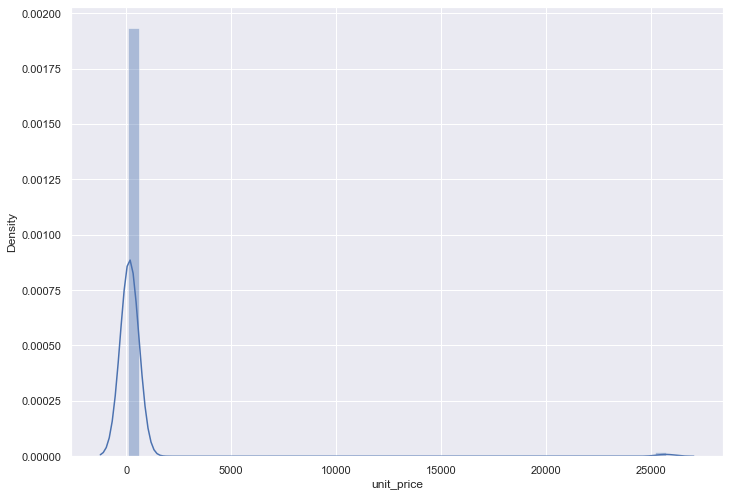

In [400]:
# A great step in the data exploration is to display the probability distribution function (PDF) of a variable
# The PDF will show us how that variable is distributed 
# This makes it very easy to spot anomalies, such as outliers
sns.distplot(shops_data['unit_price'])

# PDF prooves the assumption of the unit price issues provided in the database

In [374]:
# we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples
# Here, the outliers are situated around the higher prices (right side of the graph) that's seen as a spike
# right after 25000

# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
percentile = shops_data['unit_price'].quantile(0.99)

# Then we can create a new df, with the condition that all price units must be below the 99 
# percentile of 'price_unit'
shops_data_cleaned = shops_data[shops_data['unit_price']<percentile]

# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it

shops_data_cleaned.reset_index(drop=True,inplace=True)

# In this way we have essentially removed the top 1% of the data and unit price makes more sense now
shops_data_cleaned.describe(include='all', datetime_is_numeric=True)



,index,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,unit_price
count,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000,4903.000000,4903,4903,4903.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,credit_card,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1698,NaN,NaN
mean,2498.427085,2499.584540,49.900877,849.858862,300.155823,1.995717,NaN,2017-03-15 22:10:55.943299840,150.400163
min,0.000000,1.000000,1.000000,700.000000,90.000000,1.000000,NaN,2017-03-01 00:08:09,90.000000
25%,1244.500000,1246.500000,24.000000,776.000000,163.000000,1.000000,NaN,2017-03-08 06:23:40,132.000000
50%,2495.000000,2499.000000,50.000000,850.000000,284.000000,2.000000,NaN,2017-03-15 23:46:37,153.000000
75%,3746.500000,3750.500000,74.000000,925.000000,386.500000,3.000000,NaN,2017-03-23 10:28:42,166.000000
max,4999.000000,5000.000000,100.000000,999.000000,1086.000000,8.000000,NaN,2017-03-30 23:55:35,201.000000


Deleting data is usually not the best practice. We still can explore to what how this affect data evaluation (if any)

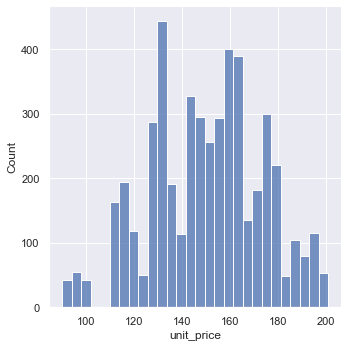

In [382]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers and overall unit price distribution makes much more sense now in terms of values
sns.displot(shops_data_cleaned['unit_price'])

In [376]:
# once we are done with the cleaning it's time to jump to AOV
# Based on multiple sources, AOV = Revenue/number of units sold
# First thing to do is to sum order amount = revenue, and total items sold based in each store separately
# and afterwards, to divide sum all orders by the number of the items sold

aov_stores = shops_data_cleaned.groupby('shop_id')['order_amount'].agg('sum')/shops_data_cleaned.groupby('shop_id')['total_items'].agg('sum')                                                                                                                                                                                                                                                                                                                                                                                   
                                                                                                       

In [388]:
# It's the same as AOV for each of the store separetely
# since all the stores have to be taken into the consideration
# one of the commonly used measure of central tendency - average, can be used here

print(aov_stores.mean())

150.22448979591837


aov = 150 $ which is within a commonly known average of sneakers price provided eariler

However, it should be noted that when it comes to measure of central tendency, it's not recommened to use
only one, but combination of such metrics to better evaluate the data that includes median and mode




In [391]:
print(aov_stores.sort_values().median())
print(aov_stores.mode())

153.0
0    153.0
dtype: float64


What if we calculate those central measures of tendencdy before cleaning?

In [445]:
# reminder, idea of unit price is the same as AOV
# mean aov for each one of the stores and their respectice central tendency values
shop_data_sorted = shops_data.groupby('shop_id')['unit_price'].agg('mean')

print(shop_data_sorted.mean())
print(shop_data_sorted.mode())
print(shop_data_sorted.median())

# 407.0 for average price? seems to be high


407.99
0    153.0
dtype: float64
153.0


### What metric would you report for this dataset? What is its value?


Based on the calculations above, I'd use median since average calculations are biased by the outliers. Although deleting data is usualy considered as a bad practice, deleting 1% of the data in order to remove outliers can still be considered as a potential solution

Another way is to investigate what causes issue

In [447]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    
    print(shops_data.groupby('shop_id')['order_amount'].agg('sum')/shops_data.groupby('shop_id')['total_items'].agg('sum'))  

shop_id
1        158.0
2         94.0
3        148.0
4        128.0
5        142.0
6        187.0
7        112.0
8        132.0
9        118.0
10       148.0
11       184.0
12       201.0
13       160.0
14       116.0
15       153.0
16       156.0
17       176.0
18       156.0
19       163.0
20       127.0
21       142.0
22       146.0
23       156.0
24       140.0
25       130.0
26       176.0
27       169.0
28       164.0
29       163.0
30       153.0
31       129.0
32       101.0
33       173.0
34       122.0
35       164.0
36       130.0
37       142.0
38       190.0
39       134.0
40       161.0
41       118.0
42       352.0
43       181.0
44       144.0
45       142.0
46       166.0
47       145.0
48       117.0
49       129.0
50       193.0
51       187.0
52       146.0
53       112.0
54       133.0
55       171.0
56       117.0
57       147.0
58       138.0
59       178.0
60       177.0
61       158.0
62       160.0
63       136.0
64       133.0
65       154.0
66       161.0
67

Seems like store 78 has some data input issues. We can recalculate central tendecies to see if it changes results much.

In [449]:
shops_no_outlier = shops_data.groupby('shop_id')['order_amount'].agg('sum')/shops_data.groupby('shop_id')['total_items'].agg('sum')

In [457]:
# let's remove store 78 data
update_df = shops_no_outlier.drop(78)

print(update_df.mean())
print(update_df.mode())
print(update_df.median())

152.26262626262627
0    153.0
dtype: float64
153.0


Once we remove the problematic store, values seem to make sense

## It was a nice challenge, hope answers provided are helpful!